# Cluster Analysis In The Private Hire Vehicles Market
## University of Exeter - College of Engineering, Mathematics and Physical Sciences
### ECMM445 - Learning From Data

#### Coursework 3 - Project 

## Candidate No: 142143

#### Part 1: Setup
##### Note: Basemap version 1.2.0 or higher is required to run this

In [22]:
#Importing basemap and fixing the issue where the variable PROJ_LIB was not being assigned and causing causing errors when importing the newest version of basemap
import os
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

#Ignoring the deprecation warnings when drawing maps using Basemap
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from matplotlib import cm

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

#Defining custom colors for basemap.
C = ['xkcd:sky blue','xkcd:violet','xkcd:mango',
     'xkcd:red','xkcd:fresh green','xkcd:dark',
     'xkcd:white','xkcd:yellow']

#### Part 2: Importing data & preprocessing

In [3]:
#Reading in the data
rides = pd.read_csv('uber-raw-data-aug14.csv')

#Converting the labels to remove special characters
rides.columns = ['timeStamp', 'lat', 'lon', 'base']

#Converting the timeStamp attribute into datetime format so it can be manipulated later on
rides['timeStamp'] = pd.to_datetime(rides['timeStamp'])

#Adding additional comments
rides['weekday'] = rides.timeStamp.dt.weekday_name
rides['day'] = rides.timeStamp.dt.day
rides['hour'] = rides.timeStamp.dt.hour
rides['minute'] = rides.timeStamp.dt.minute


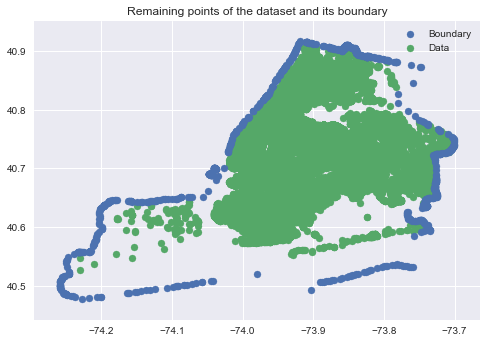

In [4]:
#Truncating dataset to store rides only from the weekends
mask = (rides['weekday']=='Friday')|(rides['weekday']=='Friday')|(rides['weekday']=='Saturday')
IDS = np.argwhere(mask).T[0]
rides = rides.iloc[IDS]
points = rides.iloc[:,[2,1]].values

#Removing any points which lay outside the boundary of NYC
import pandas
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

#Reading in the boundary data from the attached file
df = pandas.read_csv('NYC_Boundary.csv')
boundary = df.values
plt.scatter(boundary[:,0],boundary[:,1],zorder= 2)

#For some reason the polygon only forms properly when using the first 887 points of the boundary
bounds = Polygon(boundary[:887])

#Using logical indexing to remove the necessary points
mask = [bounds.contains(Point(p)) for p in points]
points = points[mask]

#Graphing the results for visualisation
plt.scatter(points[:,0],points[:,1])
plt.title('Remaining points of the dataset and its boundary')
plt.legend(['Boundary', 'Data']);

#### Part 3: K-Means Testing

In [5]:
#Creating a function to draw new york city using basemap - T
def drawNY(points = np.array([[0,0]])):
    """
    Draws a map of New York Ciy with the option of returning longitude and latitude points converted using so that they now conformto the new axis
    
    points: float array, shape = (n_points,2)
        GPS coordinates of objects to be converted 
        
    Returns
    -------
    
    X : float array, shape = (n_points,)
       Array of the longitude values converted
    
    Y : float array, shape = (n_points,)
       Array of the latitude values converted
    """
    
    fig = plt.figure(figsize=(14,8))

    #Drawin the area of New York city with custom colours for land and water
    m = Basemap(projection='merc',llcrnrlon=-74.2955, llcrnrlat=40.4653, urcrnrlon=-73.6638, urcrnrlat=40.8982,resolution='h')

    m.drawmapboundary(fill_color = 'xkcd:baby blue',zorder=-1);
    m.fillcontinents(color='xkcd:cement',zorder=0);
    m.drawcoastlines()
    m.drawrivers()
    
    #Converting the points parameter to coordinates that can be used to plot over the basemap figure
    x,y = m(points[:,0],points[:,1])
    
    return x,y


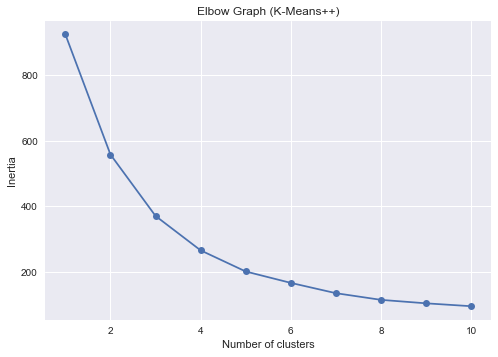

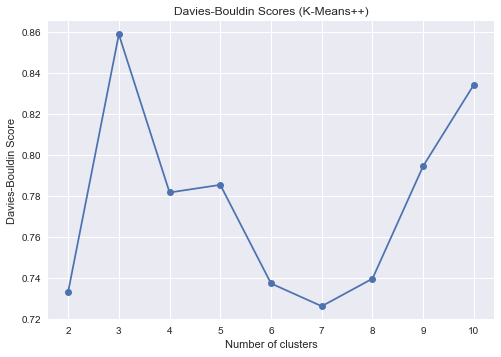

Davies-Bouldin:
[0.7330717316721703, 0.8589985143143615, 0.7817214395729587, 0.7854563924518847, 0.7372549784130764, 0.7261341983752417, 0.7396053593269197, 0.7946681956054331, 0.834475155654801]


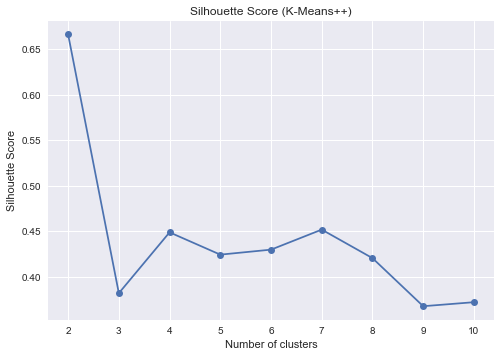

Silhouette scores:
[0.6663778227904078, 0.3821961952304288, 0.4490225632909012, 0.4245302837013367, 0.4300132268053177, 0.4520289792295714, 0.42069958498253773, 0.3678960370365104, 0.3723067431250679]


In [6]:
#Calculating evaluation metrics for K-Means
inertia, DB, SS = [], [], []
cluster_max = 10

#For loop iterating over a chosen range of cluster sizes
for i in range(1,cluster_max+1):
    
    #Fitting the K-Means ++ to the data 
    km = KMeans(n_clusters=i, init='k-means++', 
                n_init=10, max_iter=300,
                tol=1e-04, random_state=0)
    km.fit(points)
    inertia.append(km.inertia_)
    
    #Only computing out the davies boulding scores and silhouette scores when n_clusters>1
    if i>1:
        labels = km.labels_
        DB.append(davies_bouldin_score(points,labels))
        
        SS.append(silhouette_score(points,labels))

#Plotting the elbow graph using inertia values
plt.plot(range(1, cluster_max+1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Graph (K-Means++)')
plt.show();

#Plotting the Davies-Bouldin Scores
plt.plot(range(2, cluster_max+1), DB, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Scores (K-Means++)')
plt.show()

print('Davies-Bouldin:')
print(DB)

#Plotting the Silhouette Scores
plt.plot(range(2,cluster_max+1), SS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score (K-Means++)');
plt.show()

print('Silhouette scores:')
print(SS)

#### Part 4: DBSCAN Testing

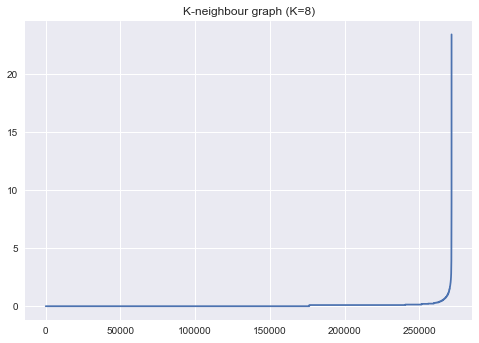

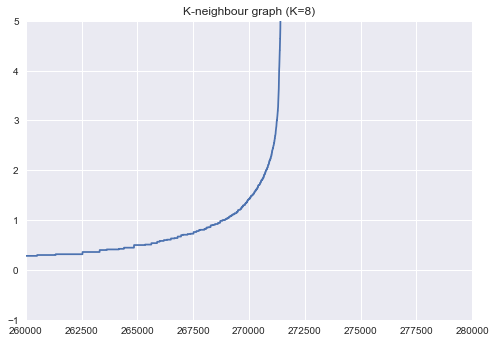

In [12]:
#Plotting the k-neighbours graph for k 
from sklearn.neighbors import NearestNeighbors

#Multiplying data by 1000 to mitiagate rounding errors
data = points*1000

#Calculating the distance to k-nearest neighbours 
nbrs = NearestNeighbors(n_neighbors=8).fit(data)
distances, indices = nbrs.kneighbors(data)

#Sorting and extracting the k-distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

#Plotting the results
plt.plot(distances)
plt.title('K-neighbour graph (K=8)')
plt.show()

plt.plot(distances)
plt.title('K-neighbour graph (K=8)')
plt.xlim([260000,280000])
plt.ylim([-1,5]);

In [14]:
def plotDBClusters(eps,min_samples):
    """
    Draws a map of New York Ciy and plots a visualistion of a DBSCAN clustering on the Uber pickup data using eps and min_samples variables
        
    eps: float
        Epsilon parameter to be used with DBSCAN
        
    min_samples: int   
        min_samples parameter to be used with DBSCAN, also commonly called minPoints
    """
    
    #Multiplying data by 1000 to mitiagate rounding errors
    data = points*1000
    
    #Fitting DBSCAN to the data and extracting the cluster labels
    DB = DBSCAN(eps=eps, min_samples=min_samples)
    DB.fit(data)
    cluster_labels = DB.labels_
    
    #Drawing new york city using basemap
    X,Y = drawNY(points)
    
    #Setting up the titles for the axes 
    ax = plt.gca()
    ax.set_title('Eps: '+str(eps)+', minPoints: '+str(min_samples)+', Samples: '+str(points.shape[0]),fontsize=15)
    
    n_clusters = max(np.unique(cluster_labels))+1
        
    #Finding the noise points and removing them from the X, Y arrays    
    noise = np.vstack((X[cluster_labels==-1],Y[cluster_labels==-1])).T
    X = X[cluster_labels!=-1]
    Y = Y[cluster_labels!=-1]
    cluster_labels = cluster_labels[cluster_labels!=-1]
    
    #Using cm.nipy_spectral to get N_clusters colours across the spectrum for each of the clusters
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    #Using logical indexing to find the first black cluster - as its usually the biggest cluster - and turnining it to blue to make it look better
    mask = np.array(colors==[0,0,0,1],dtype=int)
    mask = np.sum(mask,1)==4
    colors[mask] = [.275,.604,.89,1]
    
    #Plotting the clustered data 
    plt.scatter(X,Y,s=5,c=colors,alpha=0.6)
            
    #Plotting the noise in a greyish colour    
    plt.scatter(noise[:,0],noise[:,1], s=5, c = np.array([[.808,.839,.867,1]]) ,alpha=0.5)
    plt.show()
        
    print('n_clusters: ',n_clusters)
        

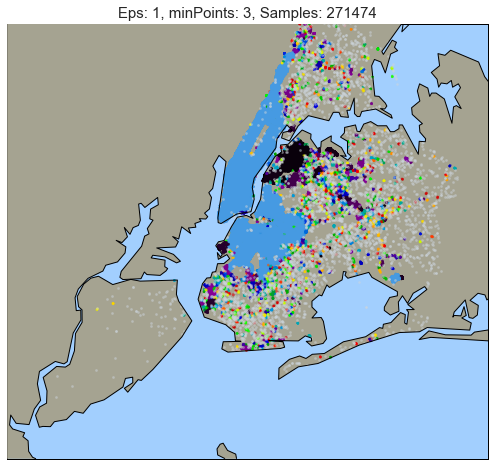

n_clusters:  1154


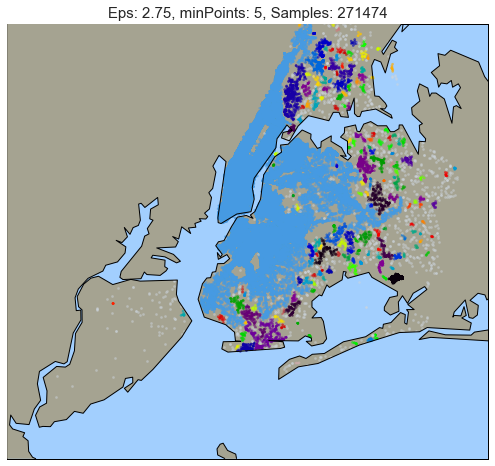

n_clusters:  177


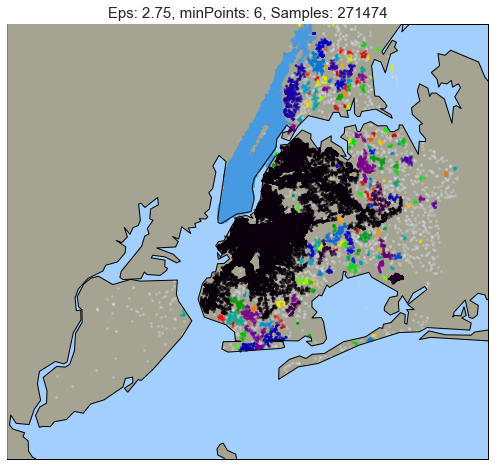

n_clusters:  168


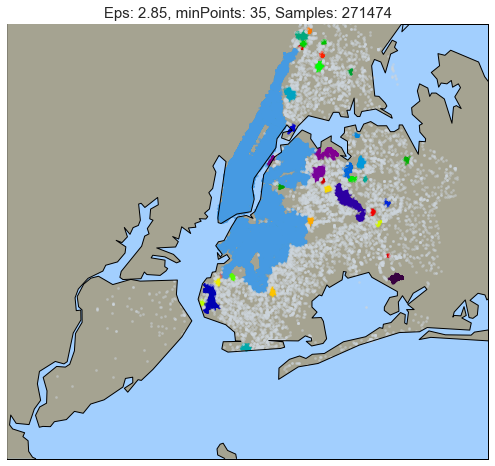

n_clusters:  37


In [15]:
plotDBClusters(1,3)
plotDBClusters(2.75,5)
plotDBClusters(2.75,6)
plotDBClusters(2.85,35)

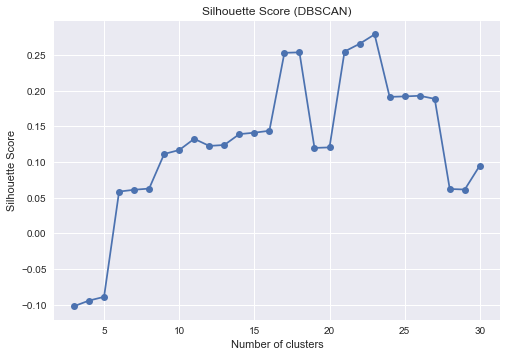

Silhouette scores:
[-0.10185015255995009, -0.09398610158624172, -0.08873553842478496, 0.05863158467079815, 0.06115084721760973, 0.06284449877171738, 0.11127680394601157, 0.11678646278072265, 0.13249813653297624, 0.12257431226320684, 0.12385569106752806, 0.13906865820260758, 0.1410751074793819, 0.14377157615053227, 0.2528857550615376, 0.25357791877030983, 0.11974676577769705, 0.12050027161117156, 0.25471607733579416, 0.26548499401347375, 0.27867132834600566, 0.19122833495642425, 0.19185609152542218, 0.1927557728360238, 0.18846555540802923, 0.0622771769479001, 0.061514849132424464, 0.09505283018589801]
Davies-Bouldin:
[0.5521493880785071, 0.5534630279257049, 0.5821862028012074, 0.6057772703997275, 0.571666568628285, 0.5577053136225955, 0.5467937937447978, 0.5460103825000473, 0.5415395016031479, 0.5170660701535166, 0.5095743954938972, 0.4924021559567574, 0.48104318276601427, 0.4804472095002401, 0.4864946537274305, 0.49578373192402214, 0.5213712484671484, 0.5172296155586572, 0.509037385111

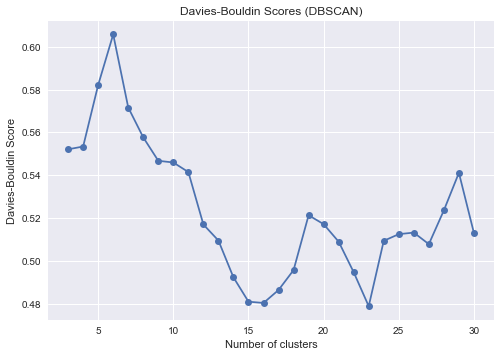

In [21]:
#Calculating evaluation metrics for DBSCAN.
data = points*1000

minPoints = np.arange(3,31)

SS = []
db = []


for n in minPoints: 
    
    #Applying DBSCAN to the data for each of the values of minPoints to be tested
    DB = DBSCAN(eps=2.75, min_samples=n)
    DB.fit(data)
    labels = DB.labels_
    
    #Removing the noise
    data_rem = points[labels!=-1]
    labels = labels[labels!=-1]
    
    #Appending Results
    SS.append(silhouette_score(data_rem,labels))
    db.append(davies_bouldin_score(data_rem,labels))

#Plotting Silhouette Scores
plt.plot(minPoints, SS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score (DBSCAN)');
plt.show()

print('Silhouette scores:')
print(SS)

#Plotting Davies Bouldin Scores
plt.plot(minPoints,db,marker='o') 
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Scores (DBSCAN)')

print('Davies-Bouldin:')
print(db)

### Part 5: Comparison

In [19]:
def plotKMClusters(n_clusters):
    """
    Draws a map of New York Ciy and plots a visualistion of a K-Means clustering on the Uber pickup data using n_clusters as the K value.
        
    n_clusters: int   
        n_clusters parameter to be used with K0Means.
    """
    
    #Fitting K-Means to the data and extracting the cluster labels
    KM = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300,  tol=1e-04, random_state=0)
    KM = KM.fit(points)
    cluster_labels = KM.labels_
    
    n_clusters = max(np.unique(cluster_labels))+1

    #Drawing new york city using basemap
    X,Y = drawNY(points)
    
    #Setting the axes labels
    ax = plt.gca()
    ax.set_title('K-Means: Number of clucters: '+str(n_clusters),fontsize=15)
    
    #Using cm.nipy_spectral to get N_clusters colours across the spectrum for each of the clusters
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    #Plotting the clustering on the New York City map 
    plt.scatter(X,Y,s=5,c=colors,alpha=0.6,zorder = 3)
    
    
    #Plotting labels on top of each of the cluster centroids
    Z = np.vstack((X,Y)).T
    centers = np.zeros((n_clusters,2))
    for i in np.arange(n_clusters):
        centers[i] = np.mean(Z[cluster_labels==i],0) 
                                
    plt.scatter(centers[:, 0], centers[:, 1], marker='o',
    c="white", zorder=9, s=300, edgecolor='k')

    for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=150, edgecolor='k',zorder=10)
    

    plt.show()

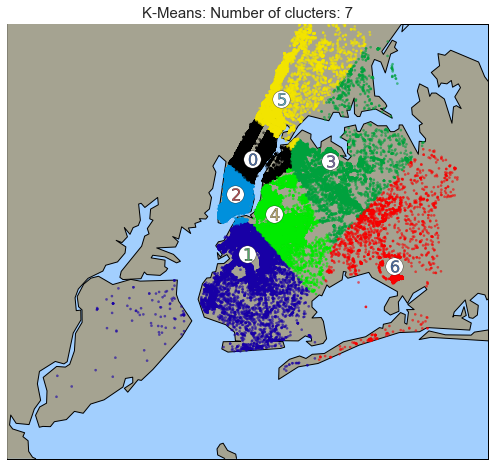

In [20]:
plotKMClusters(7)

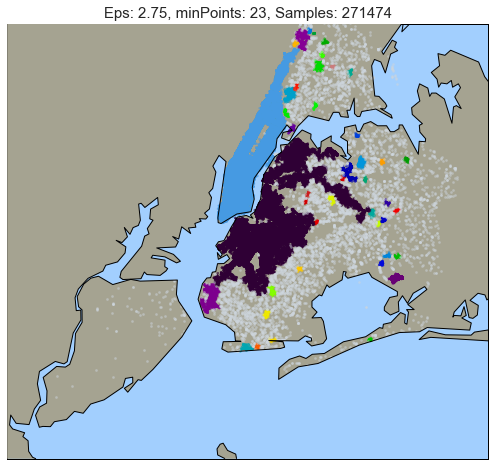

n_clusters:  44


In [18]:
plotDBClusters(2.75,23)